In [16]:
import numpy as np

#np.random.seed(42)

In [2]:
from load_data import *

# 1. load and preprocess audio and label data
#X, Y_p, phoneme = load_processed_data(max_songs=5000)

# 2. get index for label data
label_to_ix = {p:i for i,p in enumerate(phoneme)}
ix_to_label = {i:p for i,p in enumerate(phoneme)}

100%|████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 39784.57it/s]


In [3]:
from torch.utils.data import Dataset
import torch

class MFCCDataset(Dataset):
    def __init__(self, mfcc_list, label_list):
        self.mfcc_list = mfcc_list   # List of tensors (seq_len, n_mfcc)
        self.label_list = label_list # List of tensors (seq_len)

    def __len__(self):
        return len(self.mfcc_list)

    def __getitem__(self, idx):
        return self.mfcc_list[idx], self.label_list[idx]


In [4]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    mfcc_seqs, label_seqs = zip(*batch)

    mfcc_padded = pad_sequence(mfcc_seqs, batch_first=True)     # (batch_size, max_seq_len, n_mfcc)
    label_padded = pad_sequence(label_seqs, batch_first=True)   # (batch_size, max_seq_len)

    lengths = torch.tensor([seq.shape[0] for seq in mfcc_seqs]) # Original lengths

    return mfcc_padded, label_padded, lengths


In [5]:
from torch.utils.data import DataLoader
from helper_functions import *

BATCH_SIZE = 8

mfcc_list = [torch.tensor(mfcc, dtype=torch.float32) for mfcc in X]
label_list = [torch.tensor([label_to_ix[alabel[0]] for alabel in labels], dtype=torch.long) for labels in Y_p]

X_train, y_train, X_test, y_test = get_xy_split_data(mfcc_list, label_list)

train_dataset = MFCCDataset(X_train[:240], y_train[:240])
val_dataset = MFCCDataset(X_test[:60], y_test[:60])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [6]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.functional import log_softmax
from torch import nn

class PackedMFCCLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        # Pack padded sequence
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)
        
        # Unpack sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        logits = self.fc(output)
        return torch.log_softmax(logits, dim=-1)  # shape: (batch_size, max_seq_len, num_classes)


In [7]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, n_layers=2,
                bidirectional=True, dropout=0.5):
        super().__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)

        # input size for final layer
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # dropout
        self.dropout = nn.Dropout(dropout)

        # final layer (fullly connected)
        self.fc = nn.Linear(lstm_output_dim, num_classes)

    def forward(self, x, lengths):
        # pack padded sequence
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)

        # unpack sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        logits = self.fc(output)
        return torch.log_softmax(logits, dim=-1)

In [8]:
len(mfcc_list)

5000

In [9]:
len(label_list)

5000

In [10]:
len(train_dataset)

240

In [11]:
len(val_dataset)

60

In [12]:
len(train_dataloader)

30

In [13]:
len(val_dataloader)

8

In [45]:
from tqdm import tqdm  # progress bar (optional)
import torch.optim as optim
import torch.nn.functional as F

num_epochs = 30
#num_classes = model.fc.out_features  # or set manually
INPUT_DIM = 39
HIDDEN_DIM = 64
NUM_CLASSES = 41

def train(amodel, aloss_fn, lr=0.01):
    # send model to device
    amodel.to(device)
    aoptimizer = optim.Adam(amodel.parameters(), lr=lr)
    
    for epoch in tqdm(range(num_epochs)):
        amodel.train()
        total_loss = 0.0
    
        for mfcc_batch, label_batch, lengths in train_dataloader:
            # Move data to device (e.g. GPU)
            mfcc_batch = mfcc_batch.to(device)
            label_batch = label_batch.to(device)
            lengths = lengths.to(device)
    
            # Forward pass
            logits = amodel(mfcc_batch, lengths)  # shape: (batch_size, max_seq_len, num_classes)
    
            # Flatten predictions and labels for loss calculation
            logits_flat = logits.view(-1, NUM_CLASSES)
            labels_flat = label_batch.view(-1)
    
            # Loss and backprop
            loss = aloss_fn(logits_flat, labels_flat)
            aoptimizer.zero_grad()
            loss.backward()
            aoptimizer.step()
    
            total_loss += loss.item()
    
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}")



In [32]:
# Create and send model to device
model = PackedMFCCLSTM(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)

train(model, nn.CrossEntropyLoss())

  3%|██                                                          | 1/30 [00:04<02:10,  4.51s/it]

Epoch 1/30 — Loss: 3.4002


  7%|████                                                        | 2/30 [00:08<02:05,  4.47s/it]

Epoch 2/30 — Loss: 3.2782


 10%|██████                                                      | 3/30 [00:12<01:54,  4.25s/it]

Epoch 3/30 — Loss: 3.1422


 13%|████████                                                    | 4/30 [00:16<01:48,  4.16s/it]

Epoch 4/30 — Loss: 2.9221


 17%|██████████                                                  | 5/30 [00:21<01:48,  4.33s/it]

Epoch 5/30 — Loss: 2.7915


 20%|████████████                                                | 6/30 [00:25<01:42,  4.28s/it]

Epoch 6/30 — Loss: 2.6820


 23%|██████████████                                              | 7/30 [00:29<01:36,  4.21s/it]

Epoch 7/30 — Loss: 2.5784


 27%|████████████████                                            | 8/30 [00:34<01:33,  4.25s/it]

Epoch 8/30 — Loss: 2.5067


 30%|██████████████████                                          | 9/30 [00:38<01:32,  4.42s/it]

Epoch 9/30 — Loss: 2.4008


 33%|███████████████████▋                                       | 10/30 [00:43<01:26,  4.33s/it]

Epoch 10/30 — Loss: 2.3100


 37%|█████████████████████▋                                     | 11/30 [00:47<01:20,  4.25s/it]

Epoch 11/30 — Loss: 2.2207


 40%|███████████████████████▌                                   | 12/30 [00:51<01:16,  4.25s/it]

Epoch 12/30 — Loss: 2.1697


 43%|█████████████████████████▌                                 | 13/30 [00:56<01:14,  4.39s/it]

Epoch 13/30 — Loss: 2.1183


 47%|███████████████████████████▌                               | 14/30 [01:01<01:13,  4.59s/it]

Epoch 14/30 — Loss: 2.0689


 50%|█████████████████████████████▌                             | 15/30 [01:06<01:10,  4.70s/it]

Epoch 15/30 — Loss: 2.0244


 53%|███████████████████████████████▍                           | 16/30 [01:10<01:03,  4.53s/it]

Epoch 16/30 — Loss: 1.9871


 57%|█████████████████████████████████▍                         | 17/30 [01:14<00:56,  4.38s/it]

Epoch 17/30 — Loss: 1.9467


 60%|███████████████████████████████████▍                       | 18/30 [01:18<00:53,  4.43s/it]

Epoch 18/30 — Loss: 1.9229


 63%|█████████████████████████████████████▎                     | 19/30 [01:24<00:51,  4.66s/it]

Epoch 19/30 — Loss: 1.8806


 67%|███████████████████████████████████████▎                   | 20/30 [01:28<00:46,  4.66s/it]

Epoch 20/30 — Loss: 1.8395


 70%|█████████████████████████████████████████▎                 | 21/30 [01:32<00:40,  4.52s/it]

Epoch 21/30 — Loss: 1.8505


 73%|███████████████████████████████████████████▎               | 22/30 [01:37<00:36,  4.57s/it]

Epoch 22/30 — Loss: 1.8157


 77%|█████████████████████████████████████████████▏             | 23/30 [01:41<00:31,  4.45s/it]

Epoch 23/30 — Loss: 1.7783


 80%|███████████████████████████████████████████████▏           | 24/30 [01:45<00:26,  4.35s/it]

Epoch 24/30 — Loss: 1.7615


 83%|█████████████████████████████████████████████████▏         | 25/30 [01:49<00:21,  4.26s/it]

Epoch 25/30 — Loss: 1.7450


 87%|███████████████████████████████████████████████████▏       | 26/30 [01:53<00:16,  4.16s/it]

Epoch 26/30 — Loss: 1.7333


 90%|█████████████████████████████████████████████████████      | 27/30 [01:57<00:12,  4.14s/it]

Epoch 27/30 — Loss: 1.7189


 93%|███████████████████████████████████████████████████████    | 28/30 [02:01<00:08,  4.11s/it]

Epoch 28/30 — Loss: 1.6935


 97%|█████████████████████████████████████████████████████████  | 29/30 [02:05<00:04,  4.06s/it]

Epoch 29/30 — Loss: 1.6949


100%|███████████████████████████████████████████████████████████| 30/30 [02:09<00:00,  4.33s/it]

Epoch 30/30 — Loss: 1.6805


In [34]:
from sklearn.metrics import f1_score
import torch
from torch.nn.functional import log_softmax
import jiwer  # pip install jiwer if not installed

def evaluate(model, dataloader, loss_fn, device, num_classes, idx_to_token=None):
    model.eval()
    total_loss = 0.0
    per_seq_acc = []
    per_seq_f1 = []
    per_seq_wer = []
    per_seq_ids = []

    with torch.no_grad():
        for mfcc_batch, label_batch, lengths in tqdm(dataloader):
            mfcc_batch = mfcc_batch.to(device)
            label_batch = label_batch.to(device)
            lengths = lengths.to(device)

            logits = model(mfcc_batch, lengths)
            loss = loss_fn(logits.view(-1, num_classes), label_batch.view(-1))
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)  # (batch_size, seq_len)

            for i in range(len(lengths)):
                pred_seq = preds[i, :lengths[i]].cpu().tolist()
                label_seq = label_batch[i, :lengths[i]].cpu().tolist()

                # Frame Accuracy for this sequence
                correct = sum(p == l for p, l in zip(pred_seq, label_seq))
                acc = correct / lengths[i].item()
                per_seq_acc.append(acc)

                # F1 Score for this sequence
                try:
                    f1 = f1_score(label_seq, pred_seq, average="macro", zero_division=0)
                except ValueError:
                    f1 = 0.0  # In case of missing classes
                per_seq_f1.append(f1)

                # WER for this sequence (requires idx_to_token)
                if idx_to_token:
                    pred_str = flat_n_get_string([idx_to_token[p] for p in pred_seq])
                    label_str = flat_n_get_string([idx_to_token[l] for l in label_seq])
                    #pred_str = " ".join([idx_to_token[p] for p in pred_seq])
                    #label_str = " ".join([idx_to_token[l] for l in label_seq])
                    wer = jiwer.wer(label_str, pred_str)
                    per_seq_wer.append(wer)
                    # find Insertions, Deletions, Substitutions
                    editops = decode_levenshtein(pred_str, label_str)
                    per_seq_ids.append(editops)

    avg_loss = total_loss / len(dataloader)
    avg_frame_acc = sum(per_seq_acc) / len(per_seq_acc)
    avg_f1 = sum(per_seq_f1) / len(per_seq_f1)
    avg_wer = sum(per_seq_wer) / len(per_seq_wer) if per_seq_wer else None

    print(f"\n🔍 Evaluation Summary")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Average Frame Accuracy: {avg_frame_acc:.4f}")
    print(f"Average F1 Score (Macro): {avg_f1:.4f}")
    if avg_wer is not None:
        print(f"Average WER: {avg_wer:.4f}")
    else:
        print("WER skipped — provide idx_to_token to enable WER computation.")

    return {
        "loss": avg_loss,
        "frame_accuracy": avg_frame_acc,
        "f1_score": avg_f1,
        "wer": avg_wer,
        "frame_scores": per_seq_acc,
        "f1_scores": per_seq_f1,
        "wer_scores": per_seq_wer,
        "IDS": per_seq_ids
    }

metrics = evaluate(
    model, val_dataloader, nn.CrossEntropyLoss(), device,
    num_classes=NUM_CLASSES,  # number of output classes
    idx_to_token=ix_to_label  # optional for WER
)


100%|█████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.55it/s]


🔍 Evaluation Summary
Loss: 1.6290
Average Frame Accuracy: 0.3717
Average F1 Score (Macro): 0.1765
Average WER: 0.3989


In [46]:
# Create model
model_biLSTM = BiLSTM(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)

train(model_biLSTM, nn.CrossEntropyLoss())


  3%|██                                                          | 1/30 [00:13<06:28, 13.40s/it]

Epoch 1/30 — Loss: 3.4055


  7%|████                                                        | 2/30 [00:26<06:17, 13.48s/it]

Epoch 2/30 — Loss: 3.2993


 10%|██████                                                      | 3/30 [00:40<06:01, 13.39s/it]

Epoch 3/30 — Loss: 3.2198


 13%|████████                                                    | 4/30 [00:52<05:41, 13.14s/it]

Epoch 4/30 — Loss: 3.1252


 17%|██████████                                                  | 5/30 [01:05<05:26, 13.08s/it]

Epoch 5/30 — Loss: 2.9085


 20%|████████████                                                | 6/30 [01:20<05:27, 13.64s/it]

Epoch 6/30 — Loss: 2.8050


 23%|██████████████                                              | 7/30 [01:34<05:12, 13.59s/it]

Epoch 7/30 — Loss: 2.5878


 27%|████████████████                                            | 8/30 [01:49<05:08, 14.00s/it]

Epoch 8/30 — Loss: 2.4335


 30%|██████████████████                                          | 9/30 [02:01<04:46, 13.64s/it]

Epoch 9/30 — Loss: 2.3061


 33%|███████████████████▋                                       | 10/30 [02:14<04:26, 13.31s/it]

Epoch 10/30 — Loss: 2.2152


 37%|█████████████████████▋                                     | 11/30 [02:27<04:09, 13.12s/it]

Epoch 11/30 — Loss: 2.1321


 40%|███████████████████████▌                                   | 12/30 [02:40<03:59, 13.29s/it]

Epoch 12/30 — Loss: 2.0470


 43%|█████████████████████████▌                                 | 13/30 [02:53<03:43, 13.13s/it]

Epoch 13/30 — Loss: 1.9385


 47%|███████████████████████████▌                               | 14/30 [03:06<03:29, 13.07s/it]

Epoch 14/30 — Loss: 1.8699


 50%|█████████████████████████████▌                             | 15/30 [03:20<03:21, 13.45s/it]

Epoch 15/30 — Loss: 1.8181


 53%|███████████████████████████████▍                           | 16/30 [03:34<03:07, 13.39s/it]

Epoch 16/30 — Loss: 1.7133


 57%|█████████████████████████████████▍                         | 17/30 [03:46<02:51, 13.22s/it]

Epoch 17/30 — Loss: 1.6577


 60%|███████████████████████████████████▍                       | 18/30 [03:59<02:38, 13.17s/it]

Epoch 18/30 — Loss: 1.5971


 63%|█████████████████████████████████████▎                     | 19/30 [04:13<02:24, 13.17s/it]

Epoch 19/30 — Loss: 1.5266


 67%|███████████████████████████████████████▎                   | 20/30 [04:25<02:10, 13.04s/it]

Epoch 20/30 — Loss: 1.4748


 70%|█████████████████████████████████████████▎                 | 21/30 [04:39<01:59, 13.24s/it]

Epoch 21/30 — Loss: 1.4237


 73%|███████████████████████████████████████████▎               | 22/30 [04:52<01:44, 13.10s/it]

Epoch 22/30 — Loss: 1.4029


 77%|█████████████████████████████████████████████▏             | 23/30 [05:04<01:30, 12.95s/it]

Epoch 23/30 — Loss: 1.3403


 80%|███████████████████████████████████████████████▏           | 24/30 [05:18<01:18, 13.05s/it]

Epoch 24/30 — Loss: 1.3115


 83%|█████████████████████████████████████████████████▏         | 25/30 [05:32<01:06, 13.32s/it]

Epoch 25/30 — Loss: 1.2591


 87%|███████████████████████████████████████████████████▏       | 26/30 [05:44<00:52, 13.16s/it]

Epoch 26/30 — Loss: 1.2367


 90%|█████████████████████████████████████████████████████      | 27/30 [05:59<00:40, 13.51s/it]

Epoch 27/30 — Loss: 1.2151


 93%|███████████████████████████████████████████████████████    | 28/30 [06:12<00:26, 13.50s/it]

Epoch 28/30 — Loss: 1.1583


 97%|█████████████████████████████████████████████████████████  | 29/30 [06:25<00:13, 13.36s/it]

Epoch 29/30 — Loss: 1.1482


100%|███████████████████████████████████████████████████████████| 30/30 [06:39<00:00, 13.32s/it]

Epoch 30/30 — Loss: 1.1253


In [47]:
bi_metrics = evaluate(
    model_biLSTM, val_dataloader, nn.CrossEntropyLoss(), device,
    num_classes=NUM_CLASSES,  # number of output classes
    idx_to_token=ix_to_label  # optional for WER
)

100%|█████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.21it/s]


🔍 Evaluation Summary
Loss: 1.2152
Average Frame Accuracy: 0.5143
Average F1 Score (Macro): 0.3189
Average WER: 0.2787


In [68]:
import torch
from torchinfo import summary

summary(model_biLSTM)

Layer (type:depth-idx)                   Param #
BiLSTM                                   --
├─LSTM: 1-1                              153,088
├─Dropout: 1-2                           --
├─Linear: 1-3                            5,289
Total params: 158,377
Trainable params: 158,377
Non-trainable params: 0

In [69]:
summary(model)

Layer (type:depth-idx)                   Param #
PackedMFCCLSTM                           --
├─LSTM: 1-1                              26,880
├─Linear: 1-2                            2,665
Total params: 29,545
Trainable params: 29,545
Non-trainable params: 0

In [36]:
from analysis_per import *

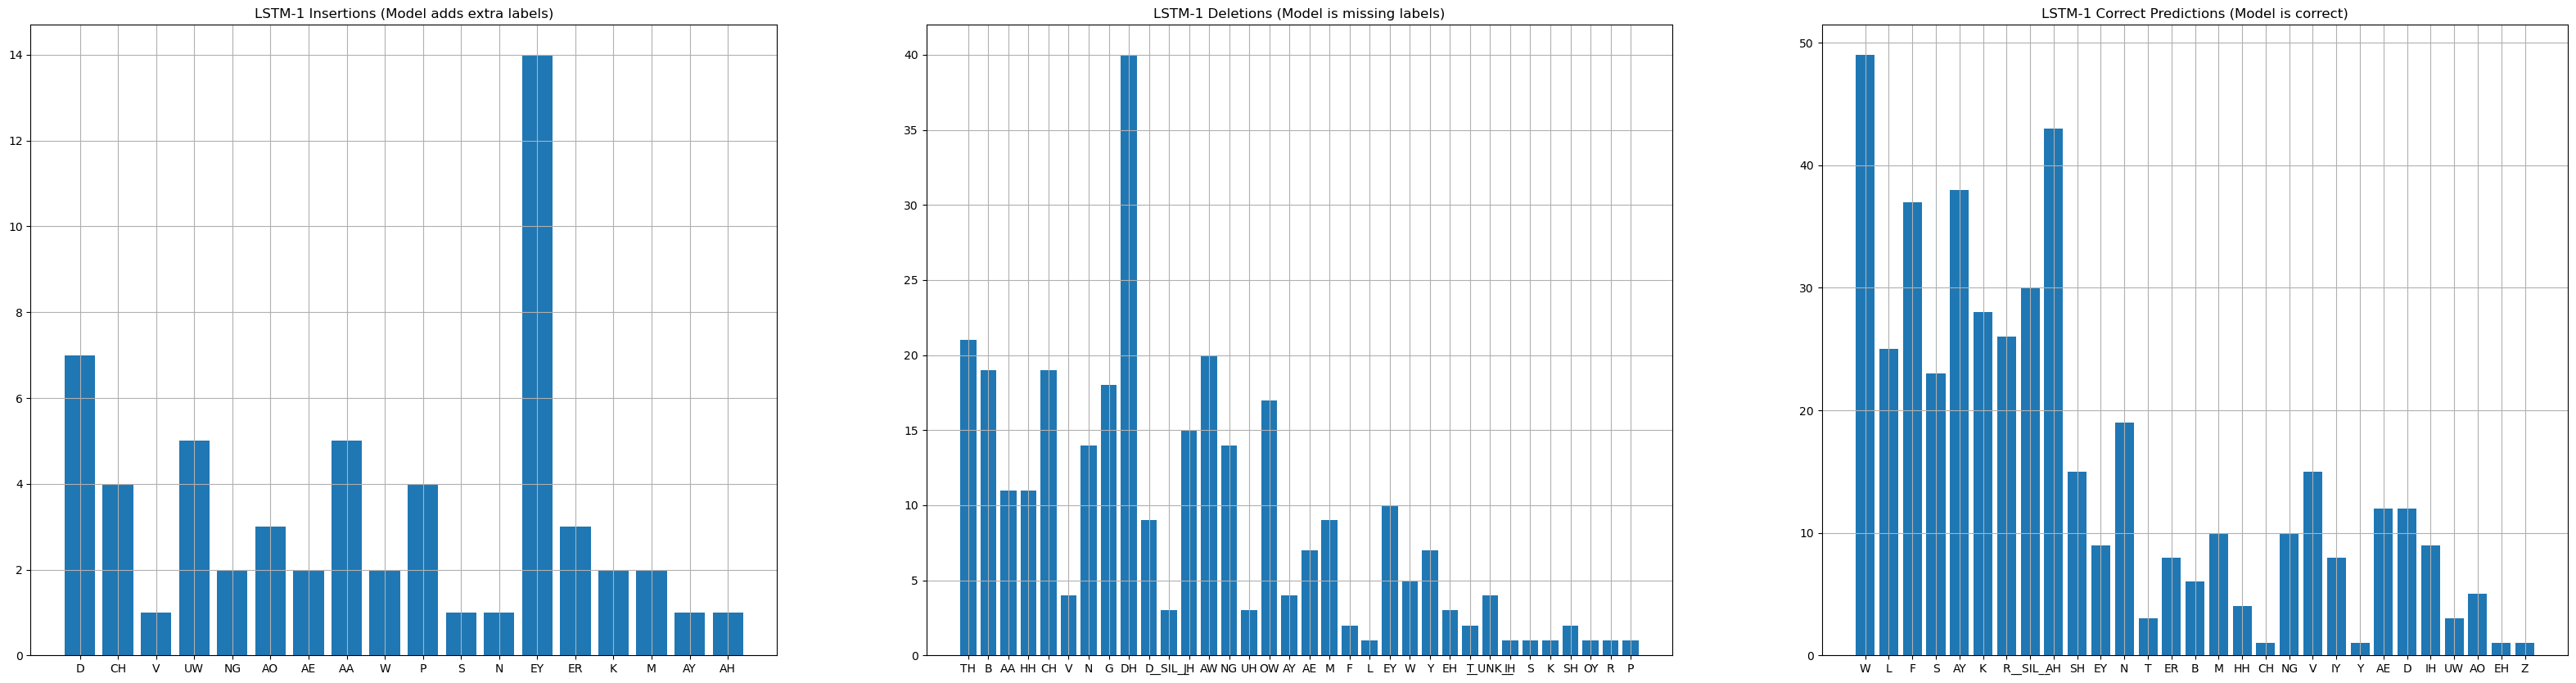

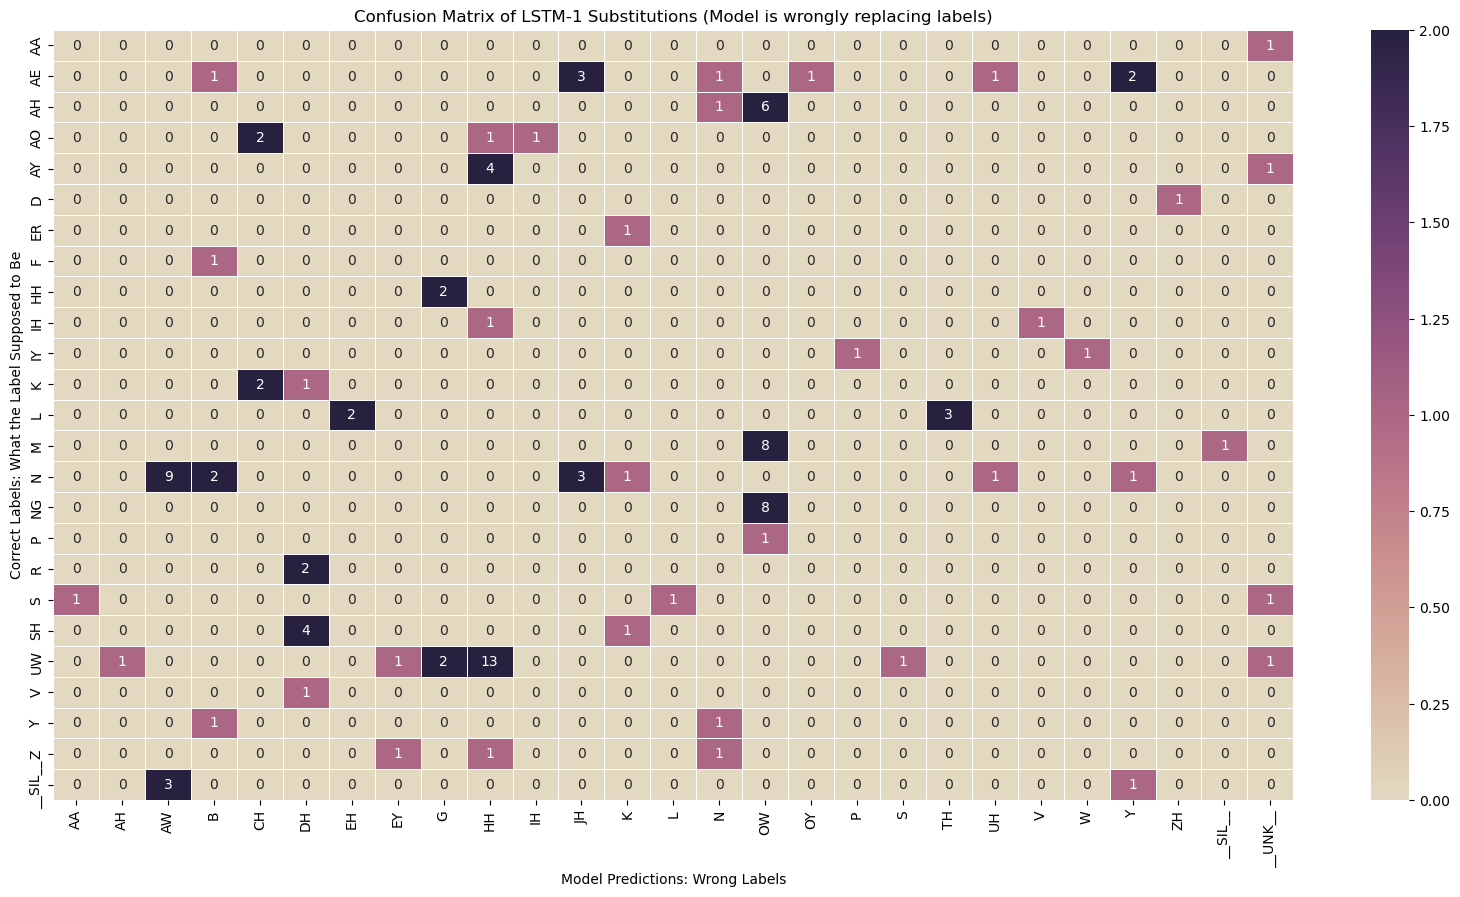

In [55]:
ids_freqd_metrics = get_freqd_ids(metrics["IDS"])
visualise_IDE(ids_freqd_metrics, model_name="LSTM-1")
visualise_S(ids_freqd_metrics["Substitutions"], model_name="LSTM-1")

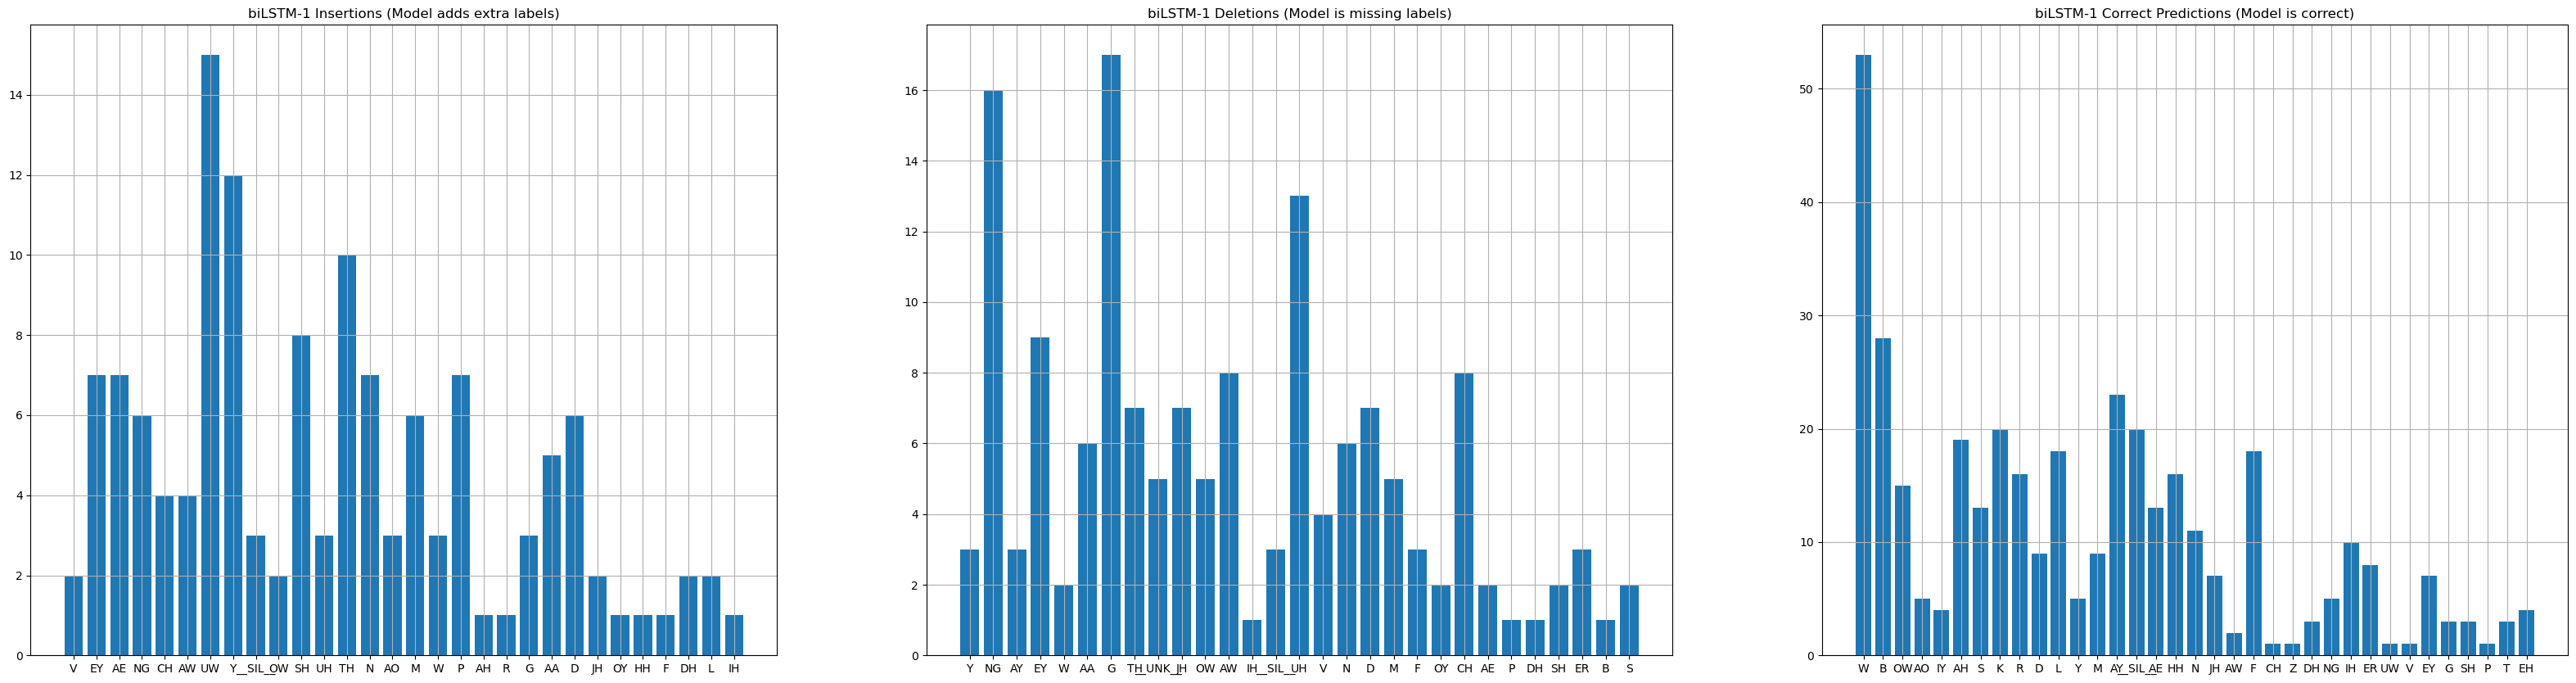

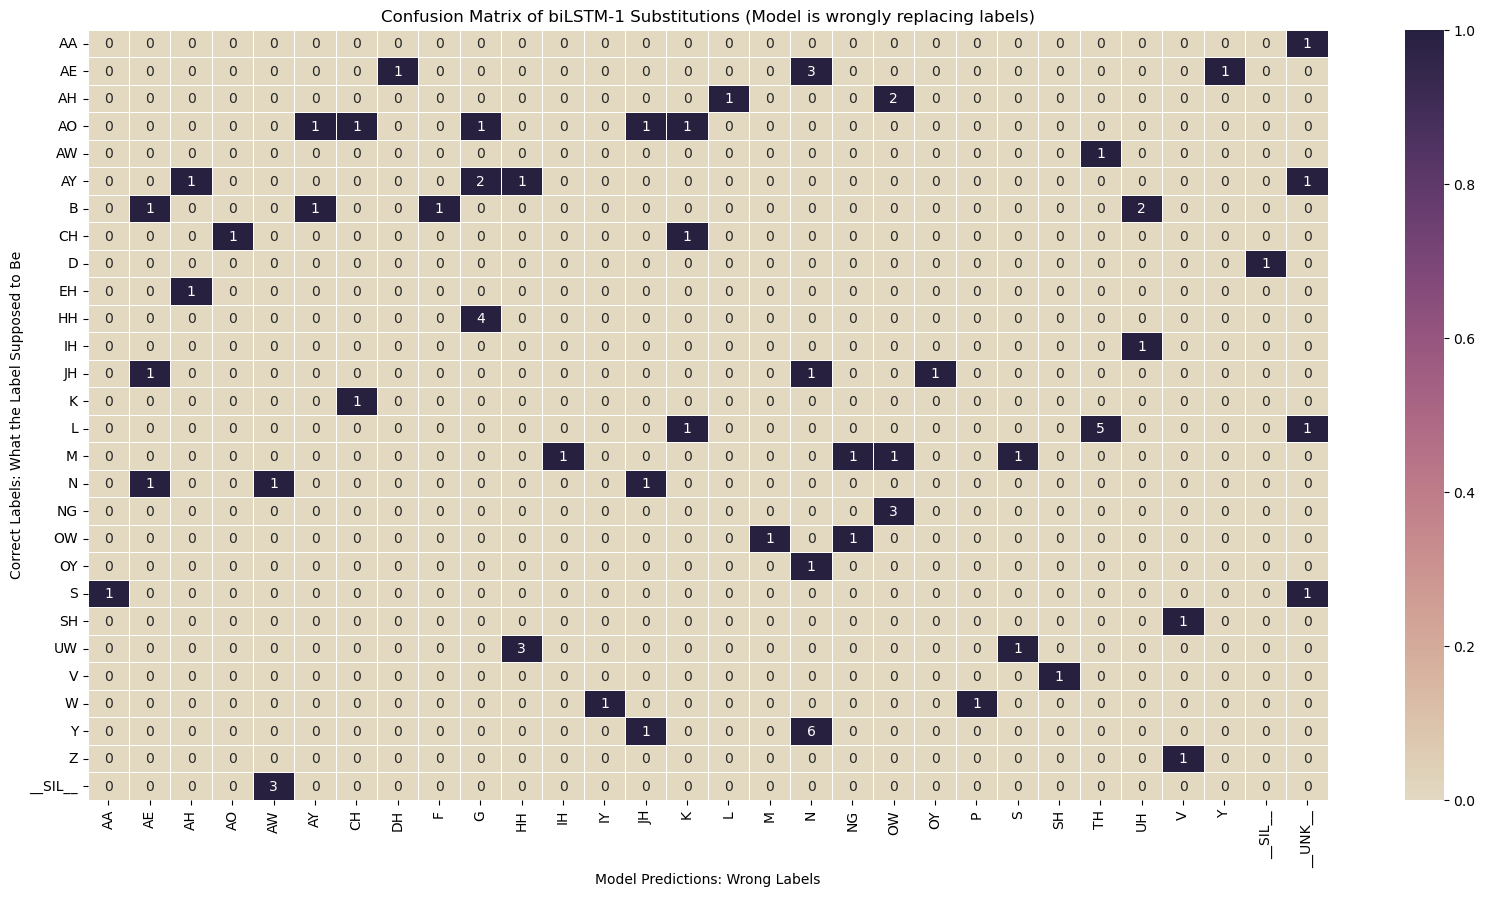

In [56]:
ids_freqd_metrics_bi = get_freqd_ids(bi_metrics["IDS"])
visualise_IDE(ids_freqd_metrics_bi, model_name="biLSTM-1")
visualise_S(ids_freqd_metrics_bi["Substitutions"], model_name="biLSTM-1")

In [65]:
sum(ids_freqd_metrics_bi["Equals"].values())

375

In [64]:
sum(ids_freqd_metrics["Equals"].values())

451

In [70]:
len(ids_freqd_metrics["Substitutions"].keys())

56

In [71]:
len(ids_freqd_metrics_bi["Substitutions"].keys())

56

In [58]:
sum(ids_freqd_metrics["Insertions"].values())

60

In [59]:
sum(ids_freqd_metrics_bi["Insertions"].values())

135

In [60]:
sum(ids_freqd_metrics["Deletions"].values())

300

In [61]:
sum(ids_freqd_metrics_bi["Deletions"].values())

152

In [62]:
sum(ids_freqd_metrics["Substitutions"].values())

117

In [63]:
sum(ids_freqd_metrics_bi["Substitutions"].values())

79